In [1]:
!pip install spacy
!python -m spacy download en_core_web_sm


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ------------ --------------------------- 3.9/12.8 MB 18.0 MB/s eta 0:00:01
     ---------------------------- ----------- 9.2/12.8 MB 21.1 MB/s eta 0:00:01
     --------------------------------------  12.6/12.8 MB 21.3 MB/s eta 0:00:01
     --------------------------------------- 12.8/12.8 MB 19.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


C:\Users\naini\AppData\Local\Temp\ipykernel_26632\2449607365.py:66: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', n_clusters)


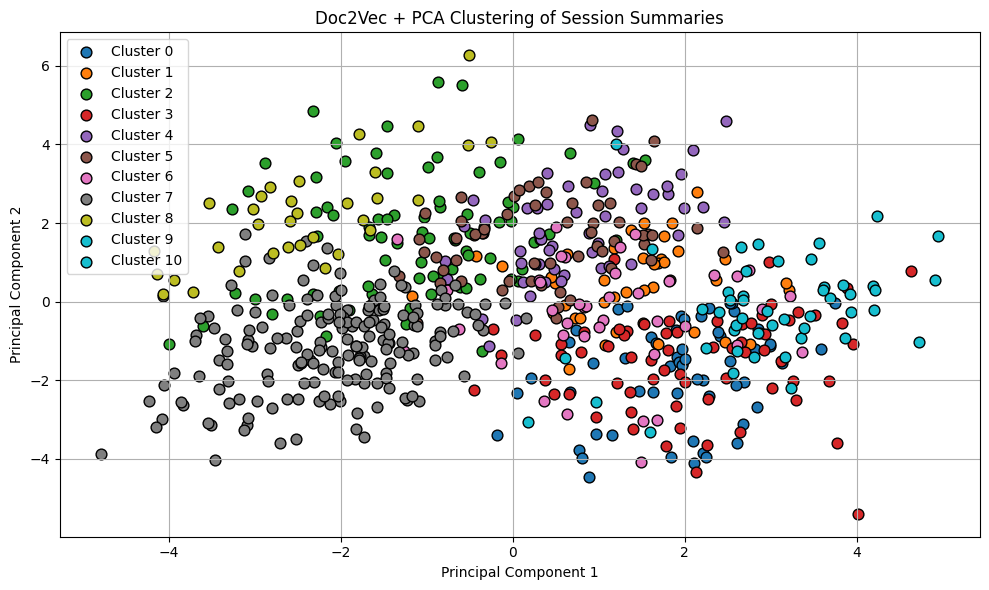


--- Quantitative Evaluation ---
Silhouette Score: 0.0510  (↑ higher is better, range -1 to 1)
Davies-Bouldin Index: 2.8121  (↓ lower is better)


In [2]:
import pandas as pd
import numpy as np
import re
import spacy
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt

# -----------------------------
# 1. Load and Clean Data
# -----------------------------
df = pd.read_excel("Session-Summary-for-E6-project.xlsx", sheet_name="Data")

# Remove empty and duplicate entries
df.dropna(subset=['Session_Summary'], inplace=True)
df.drop_duplicates(subset=['Session_Summary'], inplace=True)

# Remove URLs
df['Cleaned'] = df['Session_Summary'].apply(lambda x: re.sub(r'http\S+|www.\S+', '', x))

# -----------------------------
# 2. Lemmatization (via spaCy)
# -----------------------------
import spacy
nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"])

stopwords = set(spacy.lang.en.stop_words.STOP_WORDS)  # You can add more custom stop words if needed
def lemmatize(text):
    doc = nlp(text)
    return [token.lemma_ for token in doc if token.is_alpha and token.lemma_ not in stopwords]


documents = [TaggedDocument(lemmatize(text), [i]) for i, text in enumerate(df['Cleaned'])]

# -----------------------------
# 3. Train Doc2Vec
# -----------------------------
model = Doc2Vec(vector_size=110, window=2, min_count=4, workers=2, epochs=2000)
model.build_vocab(documents)
model.train(documents, total_examples=model.corpus_count, epochs=100)

# -----------------------------
# 4. Get Embeddings
# -----------------------------
session_vectors = [model.dv[i] for i in range(len(df))]
df_vectors = pd.DataFrame(session_vectors)
df_full = pd.concat([df.reset_index(drop=True), df_vectors], axis=1)

# -----------------------------
# 5. KMeans Clustering
# -----------------------------
n_clusters = 11
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(session_vectors)

# -----------------------------
# 6. PCA + Visualization
# -----------------------------
pca = PCA(n_components=5)
reduced = pca.fit_transform(session_vectors)

plt.figure(figsize=(10, 6))
colors = plt.cm.get_cmap('tab10', n_clusters)

for i in range(n_clusters):
    idx = labels == i
    plt.scatter(reduced[idx, 0], reduced[idx, 1],
                label=f"Cluster {i}", c=[colors(i)], edgecolors='k', s=60)

plt.title("Doc2Vec + PCA Clustering of Session Summaries")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# -----------------------------
# 7. Quantitative Evaluation
# -----------------------------
silhouette = silhouette_score(session_vectors, labels)
davies_bouldin = davies_bouldin_score(session_vectors, labels)

print("\n--- Quantitative Evaluation ---")
print(f"Silhouette Score: {silhouette:.4f}  (↑ higher is better, range -1 to 1)")
print(f"Davies-Bouldin Index: {davies_bouldin:.4f}  (↓ lower is better)")


In [29]:
cluster_range = [5, 6, 7, 8, 10 , 9 , 11 , 12 , 4 , 3, 13 ,14 , 15 ]
for clusters in cluster_range:
    kmeans = KMeans(n_clusters=clusters, random_state=42, init='k-means++')
    labels = kmeans.fit_predict(session_vectors)
    score = silhouette_score(session_vectors, labels)
    print(f"Silhouette Score for {clusters} clusters: {score:.4f}")


Silhouette Score for 5 clusters: 0.0386
Silhouette Score for 6 clusters: 0.0423
Silhouette Score for 7 clusters: 0.0506
Silhouette Score for 8 clusters: 0.0613
Silhouette Score for 10 clusters: 0.0391
Silhouette Score for 9 clusters: 0.0581
Silhouette Score for 11 clusters: 0.0532
Silhouette Score for 12 clusters: 0.0357
Silhouette Score for 4 clusters: 0.0378
Silhouette Score for 3 clusters: 0.0290
Silhouette Score for 13 clusters: 0.0484
Silhouette Score for 14 clusters: 0.0344
Silhouette Score for 15 clusters: 0.0174


Loading and preprocessing data...
Training Doc2Vec model...
Extracting document vectors...
Running KMeans clustering...
Visualizing clusters...


C:\Users\naini\AppData\Local\Temp\ipykernel_26632\416874075.py:68: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', n_clusters)


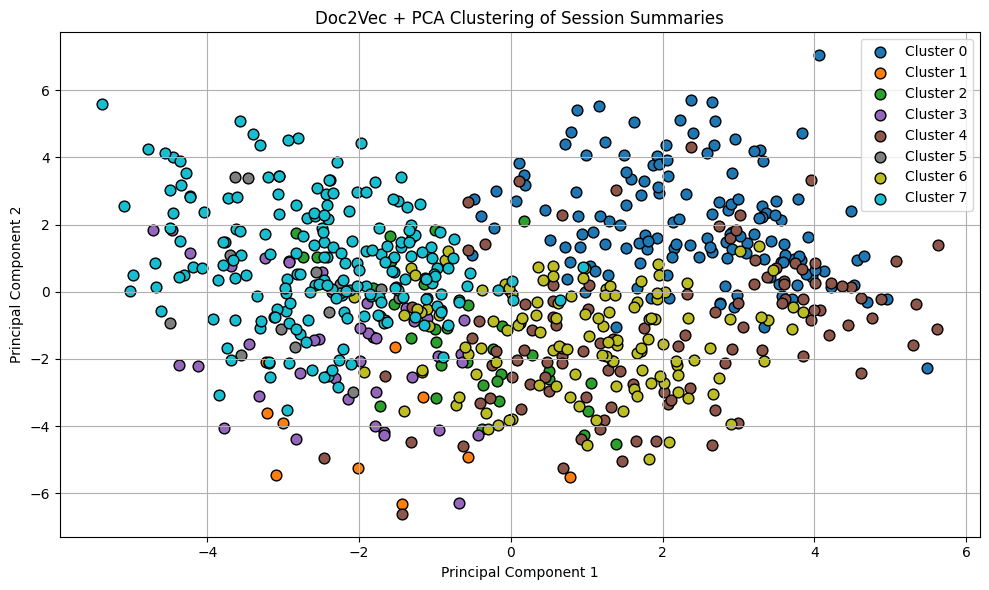

Evaluating clustering performance...

--- Quantitative Evaluation ---
Silhouette Score       : 0.0288  (↑ higher is better)
Davies-Bouldin Index   : 3.6361    (↓ lower is better)
Clustered data saved to 'clustered_session_summaries.csv'.


In [3]:
import pandas as pd
import numpy as np
import re
import spacy
import matplotlib.pyplot as plt

from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

# -----------------------------
# 1. Load & Clean Data
# -----------------------------
def load_and_clean(filepath, sheet_name="Data", text_column="Session_Summary"):
    df = pd.read_excel(filepath, sheet_name=sheet_name)
    df = df.dropna(subset=[text_column]).drop_duplicates(subset=[text_column])
    
    # Remove URLs and emails
    df["Cleaned"] = df[text_column].apply(lambda x: re.sub(r'http\S+|www\S+|mailto:\S+|\S+@\S+', '', x))
    return df.reset_index(drop=True)

# -----------------------------
# 2. Preprocessing & Lemmatization
# -----------------------------
nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"])
stopwords = set(spacy.lang.en.stop_words.STOP_WORDS)

def lemmatize(text):
    doc = nlp(text.lower())
    return [token.lemma_ for token in doc if token.is_alpha and token.lemma_ not in stopwords]

def preprocess_documents(df, text_col="Cleaned"):
    return [TaggedDocument(lemmatize(text), [i]) for i, text in enumerate(df[text_col])]

# -----------------------------
# 3. Train Doc2Vec Model
# -----------------------------
def train_doc2vec(documents, vector_size=110, window=2, min_count=4, epochs=100):
    model = Doc2Vec(vector_size=vector_size, window=window, min_count=min_count, workers=4, epochs=epochs)
    model.build_vocab(documents)
    model.train(documents, total_examples=model.corpus_count, epochs=epochs)
    return model

# -----------------------------
# 4. Get Embeddings
# -----------------------------
def get_doc_vectors(model, n_docs):
    return np.array([model.dv[i] for i in range(n_docs)])

# -----------------------------
# 5. Clustering
# -----------------------------
def run_kmeans(vectors, n_clusters=8):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(vectors)
    return labels, kmeans

# -----------------------------
# 6. PCA & Visualization
# -----------------------------
def plot_clusters(vectors, labels, n_clusters=8):
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(vectors)
    
    plt.figure(figsize=(10, 6))
    colors = plt.cm.get_cmap('tab10', n_clusters)
    
    for i in range(n_clusters):
        idx = labels == i
        plt.scatter(reduced[idx, 0], reduced[idx, 1], label=f"Cluster {i}", 
                    c=[colors(i)], edgecolors='k', s=60)
    
    plt.title("Doc2Vec + PCA Clustering of Session Summaries")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# -----------------------------
# 7. Evaluation Metrics
# -----------------------------
def evaluate_clustering(vectors, labels):
    silhouette = silhouette_score(vectors, labels)
    davies = davies_bouldin_score(vectors, labels)
    print("\n--- Quantitative Evaluation ---")
    print(f"Silhouette Score       : {silhouette:.4f}  (↑ higher is better)")
    print(f"Davies-Bouldin Index   : {davies:.4f}    (↓ lower is better)")

# -----------------------------
# 8. Main Pipeline Execution
# -----------------------------
def main():
    FILE_PATH = "Session-Summary-for-E6-project.xlsx"
    N_CLUSTERS = 8
    VECTOR_SIZE = 110
    EPOCHS = 200
    
    print("Loading and preprocessing data...")
    df = load_and_clean(FILE_PATH)
    documents = preprocess_documents(df)
    
    print("Training Doc2Vec model...")
    model = train_doc2vec(documents, vector_size=VECTOR_SIZE, epochs=EPOCHS)
    
    print("Extracting document vectors...")
    vectors = get_doc_vectors(model, len(df))
    
    print("Running KMeans clustering...")
    labels, _ = run_kmeans(vectors, n_clusters=N_CLUSTERS)
    
    print("Visualizing clusters...")
    plot_clusters(vectors, labels, n_clusters=N_CLUSTERS)
    
    print("Evaluating clustering performance...")
    evaluate_clustering(vectors, labels)

    # Append labels to DataFrame and optionally save
    df["Cluster"] = labels
    df.to_csv("clustered_session_summaries.csv", index=False)
    print("Clustered data saved to 'clustered_session_summaries.csv'.")

if __name__ == "__main__":
    main()


C:\Users\naini\AppData\Local\Temp\ipykernel_26632\3747644139.py:82: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', n_clusters)


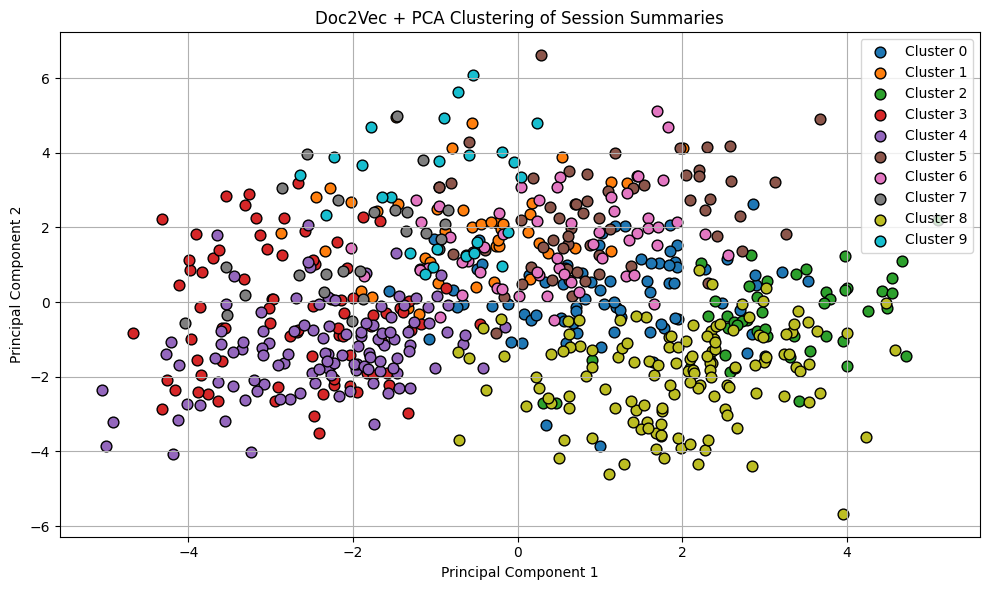


--- Best Parameters Found ---
Vector Size: 50
Window: 2
Min Count: 2
Number of Clusters: 10

--- Quantitative Evaluation ---
Silhouette Score: 0.0632  (↑ higher is better, range -1 to 1)
Davies-Bouldin Index: 2.9850  (↓ lower is better)


In [4]:
import pandas as pd
import numpy as np
import re
import spacy
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt

# Load and Clean Data
df = pd.read_excel("Session-Summary-for-E6-project.xlsx", sheet_name="Data")

# Remove empty and duplicate entries
df.dropna(subset=['Session_Summary'], inplace=True)
df.drop_duplicates(subset=['Session_Summary'], inplace=True)

# Remove URLs
df['Cleaned'] = df['Session_Summary'].apply(lambda x: re.sub(r'http\S+|www.\S+', '', x))

# Lemmatization (via spaCy)
nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"])
stopwords = set(spacy.lang.en.stop_words.STOP_WORDS)

def lemmatize(text):
    doc = nlp(text)
    return [token.lemma_ for token in doc if token.is_alpha and token.lemma_ not in stopwords]

documents = [TaggedDocument(lemmatize(text), [i]) for i, text in enumerate(df['Cleaned'])]

# Train Doc2Vec with optimized parameters
vector_sizes = [50, 100, 150]
windows = [2, 3, 4]
min_counts = [2, 4, 6]

best_silhouette = -1
best_params = None
best_vectors = None

for vector_size in vector_sizes:
    for window in windows:
        for min_count in min_counts:
            model = Doc2Vec(vector_size=vector_size, window=window, min_count=min_count, workers=2, epochs=1000)
            model.build_vocab(documents)
            model.train(documents, total_examples=model.corpus_count, epochs=100)
            
            session_vectors = [model.dv[i] for i in range(len(df))]
            
            # KMeans Clustering
            for n_clusters in range(2, 15):
                kmeans = KMeans(n_clusters=n_clusters, random_state=42)
                labels = kmeans.fit_predict(session_vectors)
                
                # Calculate Silhouette Score
                silhouette = silhouette_score(session_vectors, labels)
                
                if silhouette > best_silhouette:
                    best_silhouette = silhouette
                    best_params = (vector_size, window, min_count, n_clusters)
                    best_vectors = session_vectors

# Use the best parameters to visualize and evaluate
vector_size, window, min_count, n_clusters = best_params

# Train Doc2Vec with best parameters
model = Doc2Vec(vector_size=vector_size, window=window, min_count=min_count, workers=2, epochs=1000)
model.build_vocab(documents)
model.train(documents, total_examples=model.corpus_count, epochs=100)

session_vectors = [model.dv[i] for i in range(len(df))]

# KMeans Clustering with best number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(session_vectors)

# PCA + Visualization
pca = PCA(n_components=5)
reduced = pca.fit_transform(session_vectors)

plt.figure(figsize=(10, 6))
colors = plt.cm.get_cmap('tab10', n_clusters)

for i in range(n_clusters):
    idx = labels == i
    plt.scatter(reduced[idx, 0], reduced[idx, 1],
                label=f"Cluster {i}", c=[colors(i)], edgecolors='k', s=60)

plt.title("Doc2Vec + PCA Clustering of Session Summaries")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Quantitative Evaluation
silhouette = silhouette_score(session_vectors, labels)
davies_bouldin = davies_bouldin_score(session_vectors, labels)

print("\n--- Best Parameters Found ---")
print(f"Vector Size: {vector_size}")
print(f"Window: {window}")
print(f"Min Count: {min_count}")
print(f"Number of Clusters: {n_clusters}")

print("\n--- Quantitative Evaluation ---")
print(f"Silhouette Score: {silhouette:.4f}  (↑ higher is better, range -1 to 1)")
print(f"Davies-Bouldin Index: {davies_bouldin:.4f}  (↓ lower is better)")


C:\Users\naini\AppData\Local\Temp\ipykernel_26632\420073257.py:70: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', best_n_clusters)


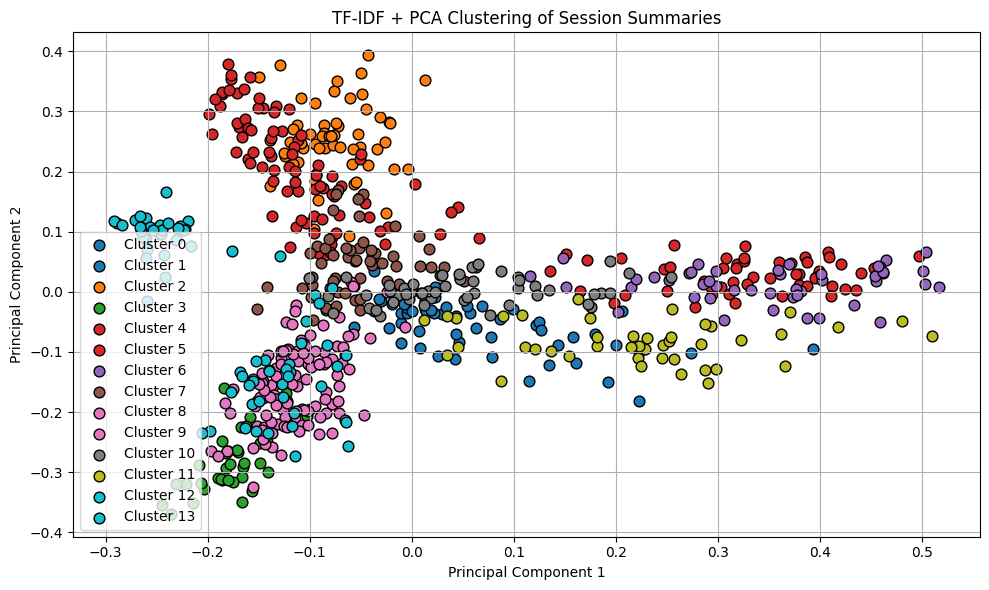


--- Quantitative Evaluation ---
Silhouette Score: 0.0653  (↑ higher is better, range -1 to 1)
Davies-Bouldin Index: 3.6020  (↓ lower is better)


In [5]:
import pandas as pd
import numpy as np
import re
import spacy
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt

# Load and Clean Data
df = pd.read_excel("Session-Summary-for-E6-project.xlsx", sheet_name="Data")

# Remove empty and duplicate entries
df.dropna(subset=['Session_Summary'], inplace=True)
df.drop_duplicates(subset=['Session_Summary'], inplace=True)

# Remove URLs and special characters
df['Cleaned'] = df['Session_Summary'].apply(lambda x: re.sub(r'http\S+|www.\S+|[^a-zA-Z0-9\s]', '', x))

# Lemmatization (via spaCy)
nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"])
stopwords = set(spacy.lang.en.stop_words.STOP_WORDS)

def lemmatize(text):
    doc = nlp(text)
    return ' '.join([token.lemma_ for token in doc if token.is_alpha and token.lemma_ not in stopwords])

df['Lemmatized'] = df['Cleaned'].apply(lemmatize)

# Vectorization using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
tfidf_vectors = vectorizer.fit_transform(df['Lemmatized'])

# Alternatively, use Doc2Vec
documents = [TaggedDocument(lemmatize(text).split(), [i]) for i, text in enumerate(df['Cleaned'])]
model = Doc2Vec(vector_size=100, window=2, min_count=4, workers=2, epochs=1000)
model.build_vocab(documents)
model.train(documents, total_examples=model.corpus_count, epochs=100)
doc2vec_vectors = [model.dv[i] for i in range(len(df))]

# Use TF-IDF vectors for clustering
vectors = tfidf_vectors.toarray()

# KMeans Clustering with dynamic cluster count
best_silhouette = -1
best_n_clusters = None

for n_clusters in range(2, 15):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(vectors)
    
    silhouette = silhouette_score(vectors, labels)
    
    if silhouette > best_silhouette:
        best_silhouette = silhouette
        best_n_clusters = n_clusters

# Use the best number of clusters for visualization
kmeans = KMeans(n_clusters=best_n_clusters, random_state=42)
labels = kmeans.fit_predict(vectors)

# PCA + Visualization
pca = PCA(n_components=5)
reduced = pca.fit_transform(vectors)

plt.figure(figsize=(10, 6))
colors = plt.cm.get_cmap('tab10', best_n_clusters)

for i in range(best_n_clusters):
    idx = labels == i
    plt.scatter(reduced[idx, 0], reduced[idx, 1],
                label=f"Cluster {i}", c=[colors(i)], edgecolors='k', s=60)

plt.title("TF-IDF + PCA Clustering of Session Summaries")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Quantitative Evaluation
silhouette = silhouette_score(vectors, labels)
davies_bouldin = davies_bouldin_score(vectors, labels)

print("\n--- Quantitative Evaluation ---")
print(f"Silhouette Score: {silhouette:.4f}  (↑ higher is better, range -1 to 1)")
print(f"Davies-Bouldin Index: {davies_bouldin:.4f}  (↓ lower is better)")
